In [6]:
import os
import numpy as np
import pandas as pd
import pandapower as pp
import pandapower.networks as pn
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 设置随机种子，保证你和我的结果一致
np.random.seed(2025)

# 绘图风格设置
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['font.family'] = 'serif'

# 检查路径是否存在，不存在则创建
save_dir = "../data/raw"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"创建目录: {save_dir}")
else:
    print(f"数据保存目录: {save_dir}")

数据保存目录: ../data/raw


In [7]:
def get_ieee33_with_pv():
    """
    加载 IEEE 33 节点系统，并在末端节点添加光伏发电机 (Static Generators)
    """
    net = pn.case33bw()
    
    # 定义光伏接入点：通常在馈线末端，电压波动最大
    # 注意：Pandapower 的 bus 索引是从 0 开始的
    # 节点 18 (Bus 17), 节点 22 (Bus 21), 节点 25 (Bus 24), 节点 33 (Bus 32)
    pv_buses = [17, 21, 24, 32] 
    
    # 为每个接入点添加光伏 (sgen)
    # 初始设为 0，后面我们在循环中动态修改
    for bus in pv_buses:
        pp.create_sgen(net, bus, p_mw=0, q_mvar=0, name=f"PV_at_Bus_{bus}")
        
    return net, pv_buses

# 测试一下模型是否加载成功
test_net, test_pv_buses = get_ieee33_with_pv()
print(f"IEEE 33 系统加载成功。")
print(f"光伏接入 Bus 索引: {test_pv_buses}")
print(f"系统总负荷: {test_net.load.p_mw.sum():.2f} MW")

IEEE 33 系统加载成功。
光伏接入 Bus 索引: [17, 21, 24, 32]
系统总负荷: 3.71 MW


In [ ]:
def run_monte_carlo_simulation(n_samples=5000):
    net, pv_buses = get_ieee33_with_pv()
    n_bus = len(net.bus)
    
    voltage_res = []
    p_inject_res = []
    q_inject_res = []
    
    base_load_p = net.load.p_mw.values.copy()
    base_load_q = net.load.q_mvar.values.copy()
    
    pv_capacity_base = 1.5 
    
    print(f"开始生成 {n_samples} 组最终样本 (三态混合：重载-正常-反送)...")
    
    for i in tqdm(range(n_samples)):
        # 引入三种模式的概率分布
        mode = np.random.choice(['heavy_load', 'high_gen', 'normal'], p=[0.4, 0.4, 0.2])
        
        if mode == 'heavy_load':
            # --- 模式 A: 严重低电压 (40%) ---
            load_scale = np.random.uniform(1.2, 1.6)
            pv_output_scaling = 0.0 
            
        elif mode == 'high_gen':
            # --- 模式 B: 严重过电压 (40%) ---
            load_scale = np.random.uniform(0.2, 0.4)
            pv_output_scaling = np.random.beta(a=5, b=2) * np.random.uniform(0.8, 1.1)
            
        else: # 'normal'
            # --- 模式 C: 正常过渡态 (20%) ---
            # 填补中间的空缺 (Load ~ 0.8, PV ~ 0.3)
            load_scale = np.random.uniform(0.5, 0.9)
            # 光伏有，但不多
            pv_output_scaling = np.random.beta(a=2, b=5) * 0.5 
        
        # --- 应用参数 ---
        node_noise = np.random.normal(1.0, 0.05, len(net.load))
        net.load.p_mw = base_load_p * load_scale * node_noise
        net.load.q_mvar = base_load_q * load_scale * node_noise
        
        pv_noise = np.random.uniform(0.9, 1.1, len(net.sgen))
        current_pv_mw = pv_capacity_base * pv_output_scaling * pv_noise
        net.sgen.p_mw = current_pv_mw 
        
        # --- 运行潮流 ---
        try:
            pp.runpp(net, algorithm='nr', init="flat")
        except pp.LoadflowNotConverged:
            continue
            
        # --- 提取数据 ---
        voltage_res.append(net.res_bus.vm_pu.values.copy())
        
        # P_net = Gen - Load
        p_net = np.zeros(n_bus)
        q_net = np.zeros(n_bus)
        
        for idx, bus_idx in enumerate(net.load.bus):
            p_net[bus_idx] -= net.load.p_mw.iloc[idx]
            q_net[bus_idx] -= net.load.q_mvar.iloc[idx]
            
        for idx, bus_idx in enumerate(net.sgen.bus):
            p_net[bus_idx] += net.sgen.p_mw.iloc[idx]
            
        p_inject_res.append(p_net)
        q_inject_res.append(q_net)
    
    return np.array(voltage_res), np.array(p_inject_res), np.array(q_inject_res)

# 生成最终的 5000 条数据 (用于训练)
V_data, P_data, Q_data = run_monte_carlo_simulation(5000)

# 再次验证图表
# (请再次运行绘图 Cell 5，这次你应该能看到两座大山之间有一座小桥)

开始生成 5000 组最终样本 (三态混合：重载-正常-反送)...


100%|██████████| 5000/5000 [00:30<00:00, 165.85it/s]


In [18]:
# 保存为 .npy 格式
np.save(os.path.join(save_dir, "voltage_magnitude.npy"), V_data)
np.save(os.path.join(save_dir, "active_power.npy"), P_data)
np.save(os.path.join(save_dir, "reactive_power.npy"), Q_data)

print("数据保存完毕。")
print(f"V Shape: {V_data.shape}")
print(f"P Shape: {P_data.shape}")

数据保存完毕。
V Shape: (5000, 33)
P Shape: (5000, 33)


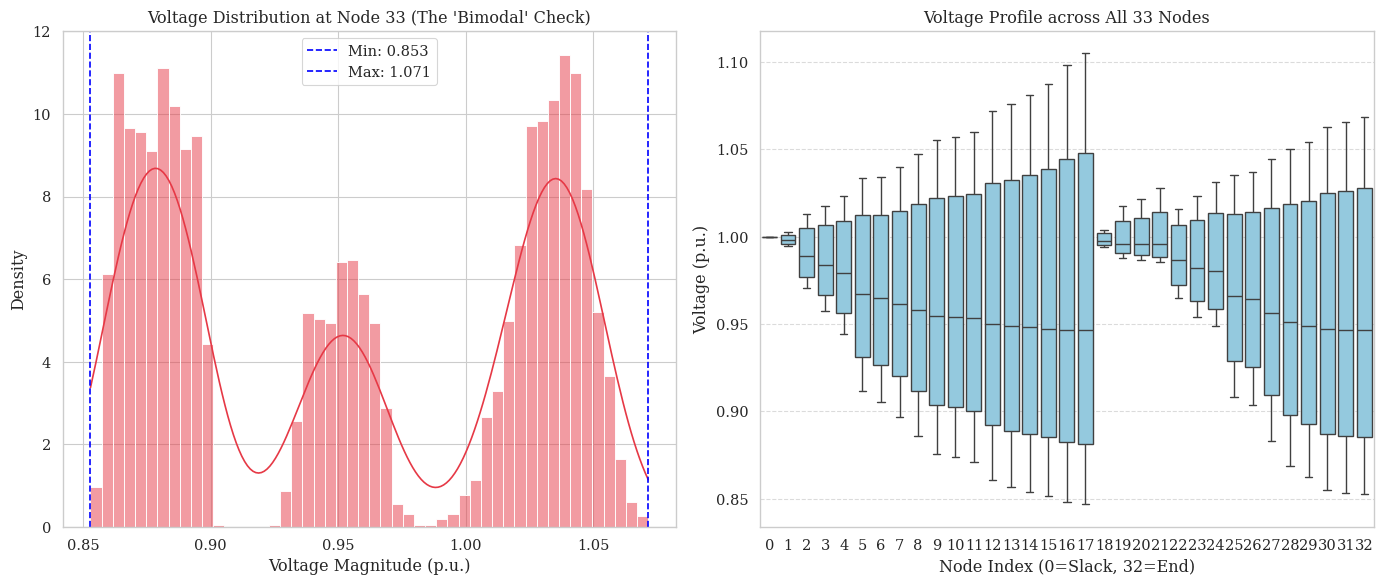

--- 自动数据质量检查 ---
1. 节点 33 电压范围: [0.8529, 1.0715] -> 跨度: 0.2185 p.u.
✅ 结果: 通过。电压波动范围足够大 (跨度 > 0.1 p.u.)。
✅ 结果: 分布正常。未发现坍缩到单点的情况。


In [19]:
# 选择末端节点进行观察 (节点 33 / Bus 32 是最容易受光伏影响的)
target_bus_idx = 32 # Node 33
v_target = V_data[:, target_bus_idx]

plt.figure(figsize=(14, 6))

# 子图 1: 特定节点的电压分布直方图 (KDE)
plt.subplot(1, 2, 1)
sns.histplot(v_target, kde=True, stat="density", color="#E63946", bins=50)
plt.title(f"Voltage Distribution at Node 33 (The 'Bimodal' Check)")
plt.xlabel("Voltage Magnitude (p.u.)")
plt.ylabel("Density")

# 在图上标出 min 和 max，看看是否够宽
plt.axvline(v_target.min(), color='blue', linestyle='--', label=f'Min: {v_target.min():.3f}')
plt.axvline(v_target.max(), color='blue', linestyle='--', label=f'Max: {v_target.max():.3f}')
plt.legend()

# 子图 2: 全网节点电压箱线图 (Boxplot)
# 这能让我们看到哪些节点电压波动大
plt.subplot(1, 2, 2)
# 只取前 200 个样本画图，避免太卡，也能看清趋势
sns.boxplot(data=V_data[:200, :], fliersize=1, color="skyblue")
plt.title("Voltage Profile across All 33 Nodes")
plt.xlabel("Node Index (0=Slack, 32=End)")
plt.ylabel("Voltage (p.u.)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 自动判断逻辑
is_range_good = (v_target.max() - v_target.min()) > 0.1
is_distribution_weird = np.mean(v_target) > 0.99 and np.std(v_target) < 0.005

print(f"--- 自动数据质量检查 ---")
print(f"1. 节点 33 电压范围: [{v_target.min():.4f}, {v_target.max():.4f}] -> 跨度: {v_target.max()-v_target.min():.4f} p.u.")
if is_range_good:
    print("✅ 结果: 通过。电压波动范围足够大 (跨度 > 0.1 p.u.)。")
else:
    print("❌ 结果: 失败。电压波动太小，可能需要增加光伏容量或负荷波动。")

if not is_distribution_weird:
    print("✅ 结果: 分布正常。未发现坍缩到单点的情况。")
else:
    print("❌ 结果: 警告。数据过于集中，可能缺少双模态特征。")

In [ ]:
import torch
import numpy as np
import pandapower.networks as pn
from torch_geometric.data import Data
import os
from tqdm import tqdm

# 确保输出目录存在
processed_dir = "../data/processed"
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)

In [ ]:
def get_ieee33_topology():
    net = pn.case33bw()
    
    # 1. Edge Index (连接关系)
    # Pandapower 的 line 表格存储了 from_bus 和 to_bus
    from_nodes = net.line.from_bus.values
    to_nodes = net.line.to_bus.values
    
    # 构建双向图 (Undirected Graph)
    # GNN 中 A-B 通常表示为 A->B 和 B->A 两条边
    src = np.concatenate([from_nodes, to_nodes])
    dst = np.concatenate([to_nodes, from_nodes])
    edge_index = torch.tensor([src, dst], dtype=torch.long)
    
    # 2. Edge Attributes (线路阻抗 R, X)
    # 物理意义：R 决定有功损耗和压降，X 决定无功压降
    # 注意单位转换：r_ohm_per_km * length_km
    r = net.line.r_ohm_per_km.values * net.line.length_km.values
    x = net.line.x_ohm_per_km.values * net.line.length_km.values
    
    # 同样拼接成双向
    r_all = np.concatenate([r, r])
    x_all = np.concatenate([x, x])
    
    # 归一化 Edge Attr (很重要，否则阻抗数值太小，梯度很难传导)
    # 我们使用简单的 Min-Max 归一化或者 Z-Score
    edge_attr = np.stack([r_all, x_all], axis=1)
    edge_attr = (edge_attr - edge_attr.mean(axis=0)) / (edge_attr.std(axis=0) + 1e-6)
    edge_attr = torch.tensor(edge_attr, dtype=torch.float32)
    
    return edge_index, edge_attr

edge_index, edge_attr = get_ieee33_topology()
print(f"拓扑构建完成: Edge Index {edge_index.shape}, Edge Attr {edge_attr.shape}")

In [ ]:
def process_data():
    # 1. 加载我们在 Step 01 生成的“黄金数据”
    raw_dir = "../data/raw"
    V = np.load(os.path.join(raw_dir, "voltage_magnitude.npy")) # [5000, 33]
    P = np.load(os.path.join(raw_dir, "active_power.npy"))      # [5000, 33]
    Q = np.load(os.path.join(raw_dir, "reactive_power.npy"))    # [5000, 33]
    
    print(f"原始数据加载: V shape={V.shape}")
    
    # 2. 计算全局统计量 (用于归一化和反归一化)
    # 我们需要保存这些 stats，以便在后续画图时把 [-1, 1] 还原回 [0.85, 1.07]
    stats = {
        'v_min': V.min(), 'v_max': V.max(),
        'p_mean': P.mean(), 'p_std': P.std(),
        'q_mean': Q.mean(), 'q_std': Q.std()
    }
    
    data_list = []
    
    print("开始封装图数据...")
    for i in tqdm(range(len(V))):
        # --- 输入特征 X (Condition) ---
        # 即使是 Diffusion，我们也需要输入条件 (P, Q)
        # Z-Score 标准化 P 和 Q
        p_norm = (P[i] - stats['p_mean']) / (stats['p_std'] + 1e-6)
        q_norm = (Q[i] - stats['q_mean']) / (stats['q_std'] + 1e-6)
        x = torch.tensor(np.stack([p_norm, q_norm], axis=1), dtype=torch.float32) # [33, 2]
        
        # --- 预测目标 Y (State) ---
        # Diffusion 的目标变量通常归一化到 [-1, 1]
        v_norm = 2 * (V[i] - stats['v_min']) / (stats['v_max'] - stats['v_min']) - 1
        y = torch.tensor(v_norm, dtype=torch.float32).view(-1, 1) # [33, 1]
        
        # 构建 Data 对象
        data = Data(x=x, y=y, edge_index=edge_index, edge_attr=edge_attr)
        data_list.append(data)
        
    # 3. 保存
    torch.save(data_list, os.path.join(processed_dir, "ieee33_graph_data.pt"))
    torch.save(stats, os.path.join(processed_dir, "data_stats.pt"))
    
    return stats

# 执行处理
stats = process_data()

print("\n=== 数据处理报告 ===")
print(f"V范围 (原始): [{stats['v_min']:.4f}, {stats['v_max']:.4f}]")
print(f"P均值/方差: {stats['p_mean']:.4f} / {stats['p_std']:.4f}")
print("处理完成。")